# Multiscale Modeling with Jeffrey's Conditioning

A simple example illustrating the core methodology of multi-scale and hidden resolution time series models as presented in the paper. We’ll focus on two levels of resolution: a fine level (daily data) and a coarse level (monthly data). The goal is to show how to update the fine level model using Jeffrey’s rule of conditioning to integrate information from the coarse level.

### Example Scenario

#### Step 1: Define the Fine Level Model
Assume we have a fine level time series $ x_t$ (e.g., daily stock prices). Let’s model $ x_t$ as an AR(1) process:

$$
x_t = \phi_x x_{t-1} + \epsilon_t
$$

$$
\epsilon_t \sim N(0, \sigma^2_x)
$$

#### Step 2: Aggregate to Coarse Level
Aggregate the daily data to monthly data by taking non-overlapping averages. Let $ y_s$ be the monthly average (coarse level) corresponding to month $ s$, where each month includes $ m$ days:

$$
y_s = \frac{1}{m} \sum_{i=1}^{m} x_{(s-1)m + i} + u_s
$$
$$
u_s \sim N(0, \tau) 
$$
#### Step 3: Define the Coarse Level Model
Assume the coarse level follows a simple AR(1) process:

$$
y_s = \phi_y y_{s-1} + \eta_s
$$
$$
\eta_s \sim N(0, \sigma^2_y)
$$

#### Step 4: Use Jeffrey’s Rule to Update the Fine Level Model
The fine and coarse level models are initially inconsistent. We use Jeffrey’s rule to revise the fine level distribution $p(x_{1:n})$ based on the updated coarse level model $q(y_{1:n_y})$.

- Define the prior model $ p(x_{1:n})$ from the AR(1) process.
- Define the link $ p(y_{1:n_y} | x_{1:n})$ by aggregating fine level data.
- Update the coarse level model to $ q(y_{1:n_y})$ using the AR(1) process for $ y_s$.
- Use Jeffrey’s rule to update the fine level model $ q(x_{1:n})$.

### Practical Steps

1. **Initial Fine Level Model**:
   $$
    p(x_{1:n}) = N(x_{1:n} | 0, V_x)
    $$
   Here, $ V_x$ is the covariance matrix of the AR(1) process.

2. **Link Between Levels**:
   $$
    p(y_{1:n_y} | x_{1:n}) = N(y_{1:n_y} | Ax_{1:n}, U)
    $$
   where $ A$ is the aggregation matrix and $ U = \tau I$.

3. **Revised Coarse Level Model**:
   $$
    q(y_{1:n_y}) = N(y_{1:n_y} | 0, Q_y)
    $$
   Here, $ Q_y$ is the covariance matrix of the AR(1) process for $ y_s$.

4. **Update Using Jeffrey’s Rule**:
   $$
    q(x_{1:n}) = \int p(x_{1:n} | y_{1:n_y}) q(y_{1:n_y}) dy_{1:n_y}
    $$

### Example Calculation

1. **Assume Parameters**:
   - $ \phi_x = 0.9, \sigma^2_x = 1$
   - $ \phi_y = 0.8, \sigma^2_y = 0.5$
   - $ m = 30$ (days in a month), $ \tau = 0.1$

2. **Generate Fine Level Data**:
   Simulate daily data $ x_t$ for $ t = 1, 2, \ldots, 360$ (one year).

3. **Aggregate to Coarse Level**:
   Compute monthly averages $ y_s$ for $ s = 1, 2, \ldots, 12$.

4. **Fit Coarse Level Model**:
   Estimate $ \phi_y$ and $ \sigma^2_y$ from the aggregated data.

5. **Update Fine Level Model**:
   Use Jeffrey’s rule to integrate the coarse level model into the fine level model.

### Simplified Example

**Daily Data (Fine Level)**:
$$
 x_t = 0.9 x_{t-1} + \epsilon_t
 $$
$$
 \epsilon_t \sim N(0, 1)
 $$

**Monthly Data (Coarse Level)**:
$$
 y_s = \frac{1}{30} \sum_{i=1}^{30} x_{(s-1) \cdot 30 + i} + u_s
 $$
$$
 u_s \sim N(0, 0.1)
 $$

**Updated Monthly Model**:
$$
 y_s = 0.8 y_{s-1} + \eta_s
 $$
$$
 \eta_s \sim N(0, 0.5)
 $$

Use Jeffrey’s rule to update $ p(x_{1:360})$ using the revised $ q(y_{1:12})$.

This simple example captures the essence of the multi-scale modeling framework. By coherently integrating information across different time scales, the model benefits from capturing both short-term and long-term dependencies, leading to better forecasting and understanding of the underlying process.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [10]:
# Update fine level model using Jeffrey's rule
def jeffreys_update(x, y_sim, phi_x, phi_y, sigma_x, sigma_y, tau, days_per_month):
    n_days = len(x)
    n_months = len(y_sim)
    updated_x = np.zeros_like(x)
    for t in range(days_per_month, n_days):
        month_idx = t // days_per_month
        if month_idx < n_months:
            updated_x[t] = (phi_x * x[t - 1] + 
                            (sigma_y / (sigma_y + tau)) * (y_sim[month_idx] - np.mean(x[(month_idx - 1) * days_per_month:month_idx * days_per_month])))
        else:
            updated_x[t] = phi_x * x[t - 1]
    return updated_x

In [ ]:
# Parameters for the fine level (daily data)
phi_x = 0.9
sigma_x = 1.0
n_days = 360  # Number of days in a year

# Parameters for the coarse level (monthly data)
phi_y = 0.8
sigma_y = 0.5
tau = 0.1
days_per_month = 30
n_months = n_days // days_per_month

# Simulate fine level data (daily data)
np.random.seed(0)
x = np.zeros(n_days)
epsilon = np.random.normal(0, sigma_x, n_days)
for t in range(1, n_days):
    x[t] = phi_x * x[t - 1] + epsilon[t]

# Aggregate to coarse level data (monthly data)
y = np.zeros(n_months)
for s in range(n_months):
    y[s] = np.mean(x[s * days_per_month:(s + 1) * days_per_month]) + np.random.normal(0, tau)

# Simulate coarse level process (monthly AR(1) model)
y_sim = np.zeros(n_months)
eta = np.random.normal(0, sigma_y, n_months)
for s in range(1, n_months):
    y_sim[s] = phi_y * y_sim[s - 1] + eta[s]

In [6]:
import pandas as pd

In [8]:
print(x.shape, y.shape, y_sim.shape)
date = list(range(1, n_days + 1))
X_df = pd.DataFrame({'date': date, 'x': x})
X_df

(360,) (12,) (12,)


,date,x
0,1,0.000000
1,2,0.400157
2,3,1.338879
3,4,3.445885
4,5,4.968854
...,...,...
355,356,-2.619177
356,357,-4.200329
357,358,-4.258270
358,359,-4.312099


In [9]:
months = list(range(1, n_months + 1))
Y_df = pd.DataFrame({'month': months, 'y': y, 'y_sim': y_sim})
Y_df

,month,y,y_sim
0,1,2.862835,0.000000
1,2,-1.109565,-0.124729
2,3,-2.367907,-0.075036
3,4,3.834256,0.186890
4,5,2.392933,0.471169
5,6,-0.022944,-0.408377
6,7,-1.507569,-0.430153
7,8,-0.441815,0.095967
8,9,-2.523120,-0.772279
9,10,0.328890,-0.424183


(360,)


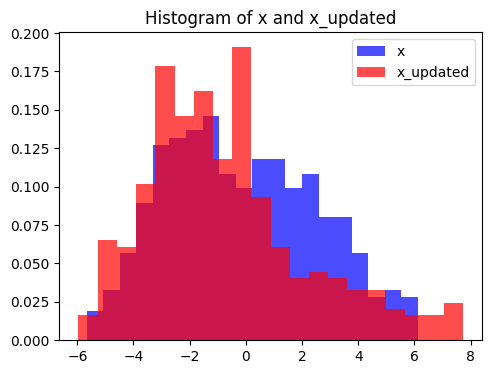

,date,x,x_updated
0,1,0.000000,0.000000
1,2,0.400157,0.000000
2,3,1.338879,0.000000
3,4,3.445885,0.000000
4,5,4.968854,0.000000
...,...,...,...
355,356,-2.619177,-2.702908
356,357,-4.200329,-2.962179
357,358,-4.258270,-4.385216
358,359,-4.312099,-4.437363


In [18]:
x_updated = jeffreys_update(x, y_sim, phi_x, phi_y, sigma_x, sigma_y, tau, days_per_month)
print(x_updated.shape)
X_updated_df = pd.DataFrame({'date': date, 'x': x, 'x_updated': x_updated})

# plot histograms of x and x_updated
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(x, bins=20, density=True, color='blue', alpha=0.7, label='x')
plt.hist(x_updated, bins=20, density=True, color='red', alpha=0.7, label='x_updated')
plt.title('Histogram of x and x_updated')
plt.legend()
plt.show()

X_updated_df


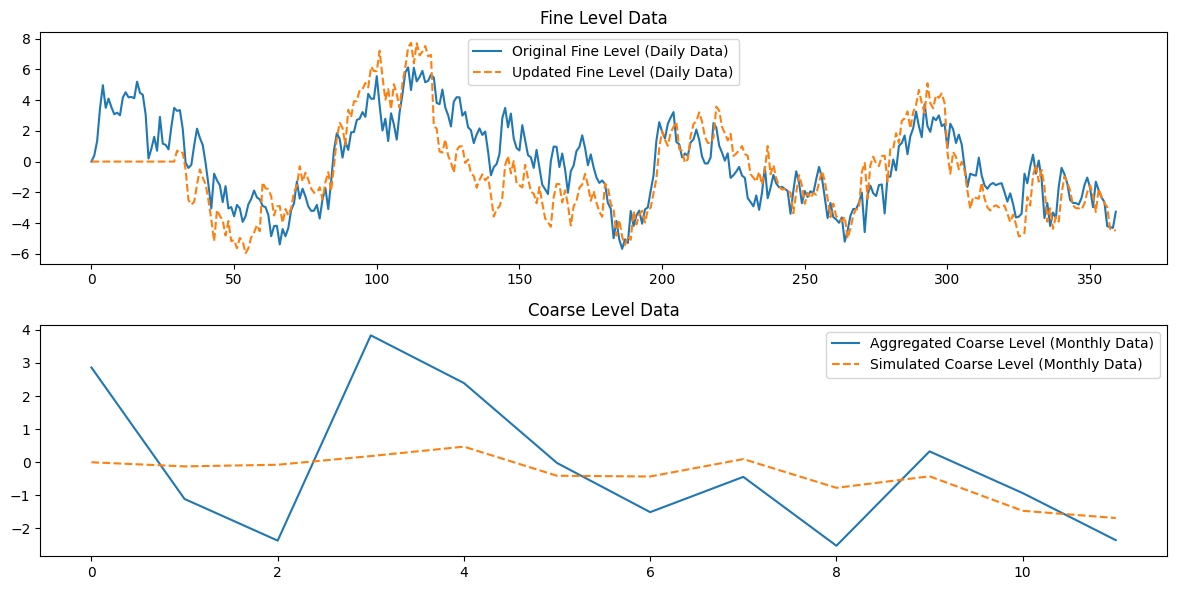

In [1]:
# Plot results
plt.figure(figsize=(12, 6))

# Fine level (daily data)
plt.subplot(2, 1, 1)
plt.plot(x, label='Original Fine Level (Daily Data)')
plt.plot(x_updated, label="Updated Fine Level (Daily Data)", linestyle='--')
plt.title('Fine Level Data')
plt.legend()

# Coarse level (monthly data)
plt.subplot(2, 1, 2)
plt.plot(y, label='Aggregated Coarse Level (Monthly Data)')
plt.plot(y_sim, label="Simulated Coarse Level (Monthly Data)", linestyle='--')
plt.title('Coarse Level Data')
plt.legend()

plt.tight_layout()
plt.show()
